In [1]:
#Importing the necessary librarires

import math
import nltk
import scipy
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,RepeatedStratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, precision_score, recall_score
from scikitplot.metrics import plot_roc_curve as auc_roc
from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20,6]
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
import warnings 
warnings.filterwarnings('ignore')

C:\Users\lenovo\anaconda3\envs\gluon\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Importing the dataset

tweets_df = pd.read_csv('tweet-sentiment-extraction/train.csv', header=0)

In [3]:
tweets_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
tweets_df.describe(include='O')

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [5]:
tweets_df.drop(['selected_text', 'textID'], axis=1, inplace=True)

In [6]:
tweets_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [7]:
target = 'sentiment'

In [8]:
original_df = tweets_df.copy(deep=True)

In [9]:
print('\n\033[1mData Dimension:\033[0m Dataset consists of {} columns & {} records.'.format(tweets_df.shape[1], tweets_df.shape[0]))


Data Dimension: Dataset consists of 2 columns & 27481 records.


In [10]:
#Checking the dtypes of all the columns

tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [11]:
#Checking the stats of all the columns

tweets_df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


### 2. Data Preprocessing

In [12]:
#Check for empty elements

tweets_df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [13]:
#Dropping the null values
tweets_df.dropna(inplace=True)
original_df = tweets_df.copy()

In [14]:
tweets_df[tweets_df.duplicated()]

,text,sentiment


In [15]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

tweets_df_dedup = tweets_df.drop_duplicates()
tweets_df_dedup.reset_index(drop=True, inplace=True)

if tweets_df_dedup.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-tweets_df_dedup.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [16]:
tweets_df_dedup.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [17]:
#Filtering the text

tweets_df_fltr = tweets_df_dedup.copy()

def preprocessor(text):
    #text = re.sub('[http:,https:]','',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.strip()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([word for word in text.split() if word.isalnum()])
    text = ' '.join([WordNetLemmatizer().lemmatize(word,pos='v') for word in text.split()])    
    #text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    #text = ' '.join([word for word in text.split() if len(word)>3])
    return text


In [18]:
tweets_df_fltr['text'] = tweets_df_dedup['text'].apply(preprocessor)


tweets_df_fltr.head()

,text,sentiment
0,respond go,neutral
1,sooo sad miss san diego,negative
2,boss bully,negative
3,interview leave alone,negative
4,sons put release already buy,negative


In [19]:
porter=PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [20]:
tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
label=tweets_df_fltr[target].values
features=tfidf.fit_transform(tweets_df_fltr.text)

In [21]:
label

array(['neutral', 'negative', 'negative', ..., 'positive', 'positive',
       'neutral'], dtype=object)

In [22]:
features

<27480x19389 sparse matrix of type '<class 'numpy.float64'>'
	with 191163 stored elements in Compressed Sparse Row format>

### 3. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


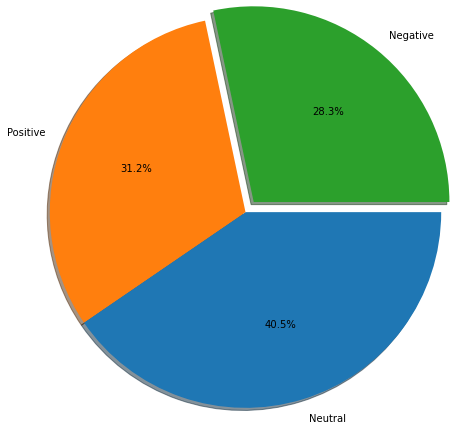

In [23]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(tweets_df_fltr[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.1], autopct='%1.1f%%', radius=1.5, startangle=0)
plt.show()